# Item-Based recommend system

In [1]:
import pandas as pd
import copy as cp

*Due to the algorithm of Item-based is logically same as the user-bases's. I just change the columns name of the rating data and put it into the algorithme of User-base.*

In [3]:
data = pd.read_csv('./dataset/ratings.csv')
data = data[['userId', 'movieId', 'rating']]
data.rename(columns={'userId':'movieId', 'movieId':'userId'}, inplace = True)


### Train test split
For each movie in all movies, select fixed portion of users who watched this movie as train set and the rest as test set.

In [4]:
def train_test_split(data, seed = 6, portion = 0.8):
    train_set = {}
    test_set = {}
    for user, movies in data.groupby('userId'):
        movies = movies.sample(frac=1, random_state=seed).reset_index(drop=True)
        train = movies[:int(portion*len(movies)) + 1]
        test = movies[int(portion*len(movies)) + 1:]
        train_set[user] = train[['movieId', 'rating']]
        test_set[user] = test[['movieId', 'rating']]
    #print('Data preparation finished')
    return train_set, test_set


In [5]:
def itemUserAndRating(train_set):
    item_user = {}
    rating = {}
    for u, items in train_set.items():
        rating[u] = {}
        movies = items['movieId'].tolist()
        ratings = items['rating'].tolist()
        for inum in range(len(movies)):
            i = movies[inum]
            rating[u][i] = ratings[inum]
            if i not in item_user.keys():
                item_user[i] = set()
            item_user[i].add(u)
    return item_user, rating


# the number of actual seen movie
#print(len(itemUserAndRating(train_set)[0]))

### theory
1. Caculate the matrix of movie similarity based on cosin similarity
2. For a specific combination of user and item, (u, i), in all the other movies which has been whatched by user u, choose the top K most similar movies to the movie i.
3. Predict the score for such combination based on those top K similar movies.

In [6]:
from operator import itemgetter
import numpy as np

def User_Similarity(train_set):
    N = {}
    C = {}
    W = {}
    for u, u_movie in train_set.items():
        N[u] = u_movie.shape[0]
        C[u] = {}
        W[u] = {}
        for v in train_set.keys():
            C[u][v] = 0
            W[u][v] = 0
    # Build inverse table
    item_user, rating = itemUserAndRating(train_set)
    for i, users in item_user.items():
        for u in users:
            for v in users:
                if v != u:
                    urating = rating[u][i]
                    vrating = rating[v][i]
                    corating = -abs(urating - vrating) + 5
                    C[u][v] += 1/np.log(1+len(users)*1.0) * corating
    
    # Calculate similarity matrix
    for u, related_users in C.items():
        for v, cuv in related_users.items():
            W[u][v] = cuv/(N[u]*N[v])**0.5
    print('user similarity finished')
    return W


Predict all the possible ratings

In [7]:
def predict(train_set, K, user_sim):
    # store the original ratings
    item_user, orig_ratings = itemUserAndRating(train_set)

    predict_ratings = cp.copy(orig_ratings)
    for u, wu in user_sim.items():  # u is the user, wu is the user similarity list of u
        # already_items is the movies already watched by u
        already_items = train_set[u]['movieId'].tolist()
        for item, vs in item_user.items():  # item is some movie, vs is the list of peopele who watched this movie
            if item not in already_items:
                # friendNum is the total amount of users we can use to predict for u with movie item
                friendNum = min(K, len(vs))
                wuv = [(v, wu[v]) for v in vs]
                topv = sorted(wuv, key=itemgetter(1), reverse=True)[
                    :friendNum]  # topv store the v id and wuv
                sum_wuv = sum([_[1] for _ in topv])
                if sum_wuv == 0:
                    #nobody wathced this movie
                    continue
                topv_normal = [(_[0], _[1]/sum_wuv)
                               for _ in topv]  # normalise the similarity
                if item not in predict_ratings[u]:
                    predict_ratings[u][item] = 0
                for v in topv_normal:
                    # the predict rating is the sum of product of related users's ratings and his similarity
                    predict_ratings[u][item] += orig_ratings[v[0]][item] * v[1]
        predict_ratings[u] = sorted(predict_ratings[u].items(), key = itemgetter(0))
    print('prediction finished.')
    return predict_ratings

In [8]:
def rmse(predict, real):
    return np.sqrt(np.mean((predict-real)**2))

In [9]:
# get the performance score of the predictions
def get_score(predictions, test_set):
    rmselist = []
    for user in test_set.keys():
        test = test_set[user]
        if test.shape[0] == 0:
            continue
        prediction = pd.DataFrame(predictions[user], columns=['movieId', user])
        merge = pd.merge(prediction, test)
        user_error = rmse(merge[user], merge['rating'])
        #print(f"For movie {user}, test error = {user_error}")
        rmselist.append(user_error)
    return np.mean(rmselist)

### Let's test the model and get the rmse score

In [10]:
train_set, test_set = train_test_split(data)
user_similarity = User_Similarity(train_set)


user similarity finished


In [11]:
predictions = predict(train_set, 10, user_similarity)
print(get_score(predictions, test_set))

prediction finished.
0.721659997445779


### Let's do the cross validation and get a more convinceble error and variance.

In [12]:
def cross_validation(data, fold = 5, K = 20):
    score_list = []
    for seed in range(fold):
        train_set, test_set = train_test_split(data, seed)
        user_similarity = User_Similarity(train_set)
        predictions = predict(train_set, K, user_similarity)
        test_score = get_score(predictions, test_set)
        print(f"test:{seed}, rmse is {test_score}.")
        score_list.append(test_score)
    return np.mean(score_list), np.var(score_list,ddof=1)

In [13]:
print(cross_validation(data))

user similarity finished
prediction finished.
test:0, rmse is 0.7387122944238057.
user similarity finished
prediction finished.
test:1, rmse is 0.7178568250488441.
user similarity finished
prediction finished.
test:2, rmse is 0.7362548906986649.
user similarity finished
prediction finished.
test:3, rmse is 0.7248845660093244.
user similarity finished
prediction finished.
test:4, rmse is 0.7107204436802412.
(0.7256858039721761, 0.00014182298741023794)


From the result, we can see the bias of this recommender system is acceptable, and the variance is very small, which means this algorithm is stable.

### Let's see how will the score change if we modify the K values

user similarity finished
prediction finished.
K:1, rmse is 0.9079590469125915.
prediction finished.
K:3, rmse is 0.7691555587680825.
prediction finished.
K:5, rmse is 0.7391032561694806.
prediction finished.
K:7, rmse is 0.7286623606092976.
prediction finished.
K:9, rmse is 0.7229917422763497.
prediction finished.
K:11, rmse is 0.7200061793573439.
prediction finished.
K:13, rmse is 0.7205295232831129.
prediction finished.
K:15, rmse is 0.7185397076203377.


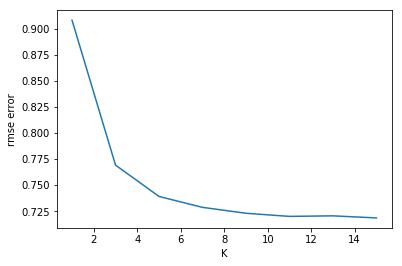

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

train_set, test_set = train_test_split(data)
error = []
x = []
user_similarity = User_Similarity(train_set)
for K in range(1, 16, 2):
    predictions = predict(train_set, K, user_similarity)
    test_score = get_score(predictions, test_set)
    print(f"K:{K}, rmse is {test_score}.")
    error.append(test_score)
    x.append(K)
plt.plot(x, error)
plt.xlabel('K')
plt.ylabel('rmse error')
plt.show()
